# regression analysis of change in specialization on change in population

Data has been trimmed to remove AK, HI, and DC

In [1]:
from pysqlite2 import dbapi2 as sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/eric/anaconda2/envs/geo/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# load data
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT
A.STATE,
A.CL8AA1990 AS pop90,
A.CL8AA2000 AS pop00,
A.CL8AA2010 AS pop10,
B.*,
C.pwhite_10,
C.pwhite_00,
C.pwhite_90,
C.diversity_4grp_10,
C.diversity_4grp_00,
C.diversity_4grp_90
FROM nhgis_pop_race_norm_90_10 AS A
JOIN county_specialization AS B
    ON A.GISJOIN = B.GISJOIN
JOIN county_diversity AS C
    ON A.GISJOIN = C.GISJOIN
;
'''

df = pd.read_sql(qry, con, index_col='GISJOIN')
con.close()
print len(df)
df.head()

3108


,STATE,pop90,pop00,pop10,Sus_10,Sstate_10,Sus_00,Sstate_00,Sus_90,Sstate_90,pwhite_10,pwhite_00,pwhite_90,diversity_4grp_10,diversity_4grp_00,diversity_4grp_90
GISJOIN,,,,,,,,,,,,,,,,
G0100010,Alabama,34223.68,43672.90,54571,0.186423,0.102048,0.152970,0.094484,0.111368,0.056898,0.772462,0.797373,0.788881,0.693947,0.615486,0.570610
G0100030,Alabama,98280.00,140415.00,182265,0.195190,0.170976,0.166580,0.159527,0.104402,0.126802,0.835048,0.860791,0.852666,0.608817,0.509665,0.488343
G0100050,Alabama,25417.62,29038.85,27457,0.344905,0.218239,0.340102,0.201792,0.322170,0.187051,0.467531,0.509257,0.552933,0.925007,0.827723,0.733707
G0100070,Alabama,16610.89,20826.41,22915,0.207588,0.079793,0.167624,0.059143,0.119096,0.053672,0.750207,0.762032,0.786280,0.675678,0.624386,0.543856
G0100090,Alabama,39251.65,51028.61,57322,0.249015,0.260330,0.226906,0.254440,0.215574,0.243790,0.888873,0.921117,0.975208,0.434742,0.343426,0.140900


In [3]:
# merge with census regions
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT A.gisjoin, B.name AS region
FROM us_county_2010 AS A, census_regions_10 AS B
WHERE ST_Contains(B.geometry, ST_Centroid(A.geometry))
AND A.ROWID IN (SELECT ROWID FROM SpatialIndex
    WHERE f_table_name = 'us_county_2010' AND search_frame = B.geometry )
;
'''

df2 = pd.read_sql(qry, con, index_col='gisjoin')
print df2.head()
con.close()
df = pd.merge(df, df2, left_index=True, right_index=True)
print len(df)

             region
gisjoin            
G3400170  Northeast
G3400110  Northeast
G2300190  Northeast
G5000090  Northeast
G5000110  Northeast
3105


**lost 3 counties with spatial join to regions**

In [4]:
# create categories for pop change 2000 to 2010
# calc pop change in each decade
df['ppctchg_0010'] = ( df['pop10'] - df['pop00'] ) * 1.0 / df['pop00'] * 100
df['ppctchg_9000'] = ( df['pop00'] - df['pop90'] ) * 1.0 / df['pop90'] * 100
# growth categories 2000-2010
df['growth_cat'] = 0
df.loc[df['ppctchg_0010'] >= 5, 'growth_cat'] = 'growing'
df.loc[(df['ppctchg_0010'] < 5) & (df['ppctchg_0010'] >= 0 ), 'growth_cat'] = 'stable'
df.loc[df['ppctchg_0010'] < 0, 'growth_cat'] = 'shrinking'
# growth categories 1990-2000
df['growth_cat_90s'] = 0
df.loc[df['ppctchg_9000'] >= 5, 'growth_cat_90s'] = 'growing'
df.loc[(df['ppctchg_9000'] < 5) & (df['ppctchg_9000'] >= 0 ), 'growth_cat_90s'] = 'stable'
df.loc[df['ppctchg_9000'] < 0, 'growth_cat_90s'] = 'shrinking'
# xtab counties between 1990s and 2000s in terms of pop change category
pd.crosstab(df['growth_cat_90s'], df['growth_cat'], margins=True)

growth_cat,growing,shrinking,stable,All
growth_cat_90s,,,,
growing,1183,287,454,1924
shrinking,46,529,99,674
stable,55,269,183,507
All,1284,1085,736,3105


In [5]:
# add vars for change in specialization
periods = [ ['90', '00'], ['00', '10'] ]
benchmarks = ['us', 'state']

for p in periods:
    start = p[0]
    end = p[1]
    for b in benchmarks:
        df['S_{}_diff_{}{}'.format(b,start,end)] = df['S{}_{}'.format(b, end)] - df['S{}_{}'.format(b, start)]
        
df.head()

,STATE,pop90,pop00,pop10,Sus_10,Sstate_10,Sus_00,Sstate_00,Sus_90,Sstate_90,...,diversity_4grp_90,region,ppctchg_0010,ppctchg_9000,growth_cat,growth_cat_90s,S_us_diff_9000,S_state_diff_9000,S_us_diff_0010,S_state_diff_0010
G0100010,Alabama,34223.68,43672.90,54571,0.186423,0.102048,0.152970,0.094484,0.111368,0.056898,...,0.570610,South,24.953919,27.610181,growing,growing,0.041602,0.037586,0.033453,0.007564
G0100030,Alabama,98280.00,140415.00,182265,0.195190,0.170976,0.166580,0.159527,0.104402,0.126802,...,0.488343,South,29.804508,42.872405,growing,growing,0.062179,0.032725,0.028610,0.011449
G0100050,Alabama,25417.62,29038.85,27457,0.344905,0.218239,0.340102,0.201792,0.322170,0.187051,...,0.733707,South,-5.447358,14.246928,shrinking,growing,0.017932,0.014741,0.004804,0.016447
G0100070,Alabama,16610.89,20826.41,22915,0.207588,0.079793,0.167624,0.059143,0.119096,0.053672,...,0.543856,South,10.028565,25.378050,growing,growing,0.048528,0.005471,0.039964,0.020650
G0100090,Alabama,39251.65,51028.61,57322,0.249015,0.260330,0.226906,0.254440,0.215574,0.243790,...,0.140900,South,12.333062,30.003732,growing,growing,0.011333,0.010650,0.022109,0.005890


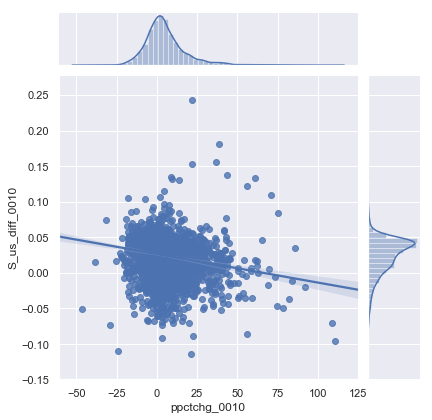

In [6]:
# plot pct pop change and specialization difference 2000-2010
sns.jointplot('ppctchg_0010', 'S_us_diff_0010', df, kind='reg')

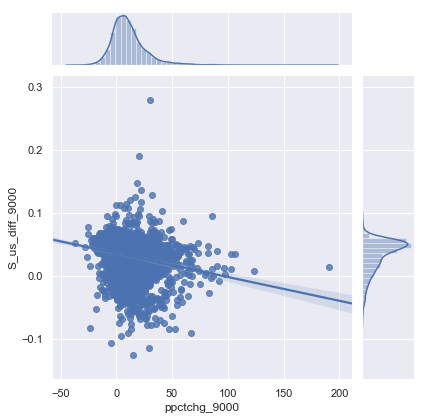

In [7]:
# look at 1990-2000
sns.jointplot('ppctchg_9000', 'S_us_diff_9000', df, kind='reg')

Text(0.5,1,u'2000-2010')

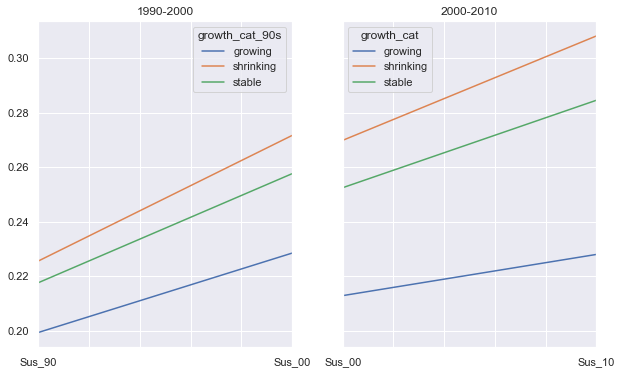

In [8]:
# plot change in median specialization across periods
# note that some counties in are in diff growth_cat in each period
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,6))
cols1 = ['Sus_90', 'Sus_00']
cols2 = ['Sus_00', 'Sus_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax1)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

In [9]:
# regress change in specialization (t2 - t1)  on pop change
m = 'S_us_diff_0010 ~ ppctchg_0010'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     59.95
Date:                Thu, 18 Oct 2018   Prob (F-statistic):           1.31e-14
Time:                        10:58:18   Log-Likelihood:                 6880.0
No. Observations:                3105   AIC:                        -1.376e+04
Df Residuals:                    3103   BIC:                        -1.374e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0266      0.001     52.504   

baseline bivariate model indicates that an increase in population is related to a decline in specialization. the magnitude of the relationship is quite small. a 10% increase in population is associated with a -0.004 decline in specialization. the range of values for this variable are quite small though. this model does not tell us about population loss, only the degree to which more or less change in population is associated with changes in specialization.

In [10]:
df['S_us_diff_0010'].describe()

count    3105.000000
mean        0.024504
std         0.026922
min        -0.114638
25%         0.009887
50%         0.029987
75%         0.042682
max         0.242465
Name: S_us_diff_0010, dtype: float64

In [11]:
# regress change in specialization (t2 - t1)  on pop change
m = 'S_us_diff_0010 ~ ppctchg_0010 + np.log(pop00) + pwhite_00 + STATE + region'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     21.37
Date:                Thu, 18 Oct 2018   Prob (F-statistic):          5.30e-169
Time:                        10:58:18   Log-Likelihood:                 7294.2
No. Observations:                3105   AIC:                        -1.448e+04
Df Residuals:                    3053   BIC:                        -1.417e+04
Df Model:                          51                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [12]:
# regress change in specialization (t2 - t1)  on pop change
m = 'S_us_diff_9000 ~ ppctchg_9000 + np.log(pop90) + pwhite_90 + STATE + region'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_9000   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     31.28
Date:                Thu, 18 Oct 2018   Prob (F-statistic):          1.98e-244
Time:                        10:58:18   Log-Likelihood:                 7168.4
No. Observations:                3105   AIC:                        -1.423e+04
Df Residuals:                    3053   BIC:                        -1.392e+04
Df Model:                          51                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# piecewise regression
if we want to say something specifically about the impact of _loss_ on changing diversity, we might want to incorporate growth and loss in piecewise fashion. Population change does not directly tell us about loss

In [13]:
# create piecewise variables
# gen new var with increasing values for pop change tracts alone
df['pop_loss'] = 0
df.loc[df['ppctchg_0010'] < 0, 'pop_loss'] = df['ppctchg_0010'] * -1
df['intl'] = 1
df.loc[df['ppctchg_0010'] >= 0, 'intl'] = 0

df['pop_gain'] = 0
df.loc[df['ppctchg_0010'] >= 0, 'pop_gain'] = df['ppctchg_0010']
df['intg'] = 1
df.loc[df['ppctchg_0010'] < 0, 'intg'] = 0

In [14]:
# how many loss counties?
print len(df.loc[df['ppctchg_0010']<0])
# how many growth?
print len(df.loc[df['ppctchg_0010']>=0])

1085
2020


In [15]:
# regress change in specialization (t2 - t1)  on pop change
m = 'S_us_diff_0010 ~ pop_loss + pop_gain + np.log(pop00) + pwhite_00 + STATE + region'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     21.02
Date:                Thu, 18 Oct 2018   Prob (F-statistic):          1.06e-168
Time:                        10:58:18   Log-Likelihood:                 7297.1
No. Observations:                3105   AIC:                        -1.449e+04
Df Residuals:                    3052   BIC:                        -1.417e+04
Df Model:                          52                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [16]:
# try with dummy variables for gain and loss to check for non-linear effect
# regress change in specialization (t2 - t1)  on pop change
m = 'S_us_diff_0010 ~ intl + np.log(pop00) + pwhite_00 + STATE + region'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     21.53
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          2.82e-170
Time:                        22:19:26   Log-Likelihood:                 7279.7
No. Observations:                3105   AIC:                        -1.446e+04
Df Residuals:                    3053   BIC:                        -1.414e+04
Df Model:                          51                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [16]:
# try with dummy variables for gain and loss to check for non-linear effect
# regress change in specialization (t2 - t1)  on pop change
m = 'S_us_diff_0010 ~ intl + np.log(pop00) + pwhite_00 + STATE + region'
results = smf.ols(m, data=df.loc[df['growth_cat']!='stable']).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     15.72
Date:                Thu, 18 Oct 2018   Prob (F-statistic):          1.19e-117
Time:                        10:59:13   Log-Likelihood:                 5510.5
No. Observations:                2369   AIC:                        -1.092e+04
Df Residuals:                    2317   BIC:                        -1.062e+04
Df Model:                          51                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# predicted values

can't use sfm to generate predicted values. need to create dummies outside of the formula.

In [17]:
# generate new vars for prediction 
df['pop00_ln'] = np.log(df['pop00'])

dummy_regions = pd.get_dummies(df['region'], prefix='region')

cols_to_keep = ['S_us_diff_0010', 'ppctchg_0010', 'pop00_ln', 'pwhite_00']
data = df[cols_to_keep].join(dummy_regions.loc[:, 'region_Northeast':])
data['intercept'] = 1.0
data.head()

,S_us_diff_0010,ppctchg_0010,pop00_ln,pwhite_00,region_Northeast,region_South,region_West,intercept
G0100010,0.033453,24.953919,10.684483,0.797373,0,1,0,1.0
G0100030,0.028610,29.804508,11.852358,0.860791,0,1,0,1.0
G0100050,0.004804,-5.447358,10.276390,0.509257,0,1,0,1.0
G0100070,0.039964,10.028565,9.943977,0.762032,0,1,0,1.0
G0100090,0.022109,12.333062,10.840142,0.921117,0,1,0,1.0


In [18]:
# remove DV from dataframe to supply to reg model
train_cols = data.columns[1:]

In [19]:
# run model
results = sm.OLS(data['S_us_diff_0010'], data[train_cols]).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     89.17
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          1.80e-103
Time:                        22:19:26   Log-Likelihood:                 7188.0
No. Observations:                3105   AIC:                        -1.436e+04
Df Residuals:                    3098   BIC:                        -1.432e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ppctchg_0010        -0.0003    6.4e-05  

In [20]:
# create dataframe of values based on model results

def cartesian(arrays, out=None):

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [21]:
pop_chgs = np.linspace(data['ppctchg_0010'].min(), data['ppctchg_0010'].max(), 10)
print pop_chgs

[ -46.604856    -29.16527687  -11.72569773    5.7138814    23.15346054
   40.59303967   58.03261881   75.47219794   92.91177708  110.35135621]


In [22]:
# take median 2000 population
np.log(df['pop00'].median())

10.11795356265665

In [23]:
# take median pct white in 2000
df['pwhite_00'].median()

0.8934603433649365

In [24]:
# enumerate all possibilities
combos = pd.DataFrame(cartesian([pop_chgs, [0.90], [1, 2, 3, 4], [ 1. ], [10]]))
combos.columns = ['ppctchg_0010', 'pwhite_00', 'region', 'intercept', 'pop00_ln']
combos.head()

,ppctchg_0010,pwhite_00,region,intercept,pop00_ln
0,-46.604856,0.9,1.0,1.0,10.0
1,-46.604856,0.9,2.0,1.0,10.0
2,-46.604856,0.9,3.0,1.0,10.0
3,-46.604856,0.9,4.0,1.0,10.0
4,-29.165277,0.9,1.0,1.0,10.0


In [39]:
# recreate the dummy variables
dummy_ranks = pd.get_dummies(combos['region'], prefix='region')
dummy_ranks.columns = ['region_Midwest', 'region_Northeast', 'region_South', 'region_West']
# keep only what we need for making predictions
cols_to_keep = ['ppctchg_0010', 'pwhite_00', 'region', 'intercept', 'pop00_ln']
combos = combos[cols_to_keep].join(dummy_ranks.loc[:, 'region_Northeast':])
combos.head()

,ppctchg_0010,pwhite_00,region,intercept,pop00_ln,region_Northeast,region_South,region_West
0,-46.604856,0.9,1.0,1.0,10.0,0,0,0
1,-46.604856,0.9,2.0,1.0,10.0,1,0,0
2,-46.604856,0.9,3.0,1.0,10.0,0,1,0
3,-46.604856,0.9,4.0,1.0,10.0,0,0,1
4,-29.165277,0.9,1.0,1.0,10.0,0,0,0


In [26]:
# make predictions on the enumerated dataset
combos['dif_div_pred'] = results.predict(combos[train_cols])

In [27]:
combos.head()

,ppctchg_0010,pwhite_00,region,intercept,pop00_ln,region_Northeast,region_South,region_West,dif_div_pred
0,-46.604856,0.9,1.0,1.0,10.0,0,0,0,0.047558
1,-46.604856,0.9,2.0,1.0,10.0,1,0,0,0.042687
2,-46.604856,0.9,3.0,1.0,10.0,0,1,0,0.047379
3,-46.604856,0.9,4.0,1.0,10.0,0,0,1,0.046284
4,-29.165277,0.9,1.0,1.0,10.0,0,0,0,0.041720


In [28]:
grouped = pd.pivot_table(combos, values=['dif_div_pred'], index=['ppctchg_0010', 'region'], aggfunc=np.mean)
print grouped.head()

                     dif_div_pred
ppctchg_0010 region              
-46.604856   1.0         0.047558
             2.0         0.042687
             3.0         0.047379
             4.0         0.046284
-29.165277   1.0         0.041720


(-0.10851461159420155, 0.17281358231290717)

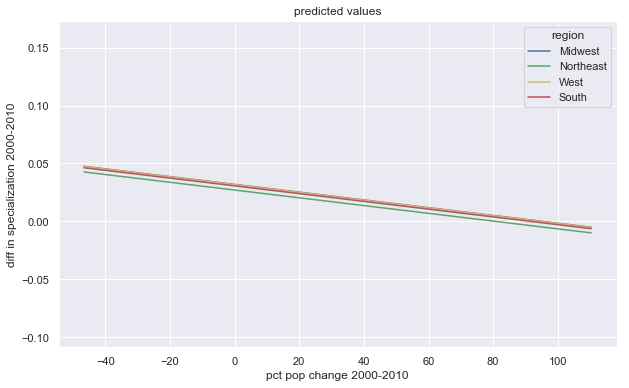

In [29]:
fix, ax = plt.subplots(figsize=(10,6))
colors = 'rbgyrbgy'
for col in combos.region.unique():
    plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
    plt.plot(plt_data.index.get_level_values(0), plt_data['dif_div_pred'], color=colors[int(col)])
    
plt.legend(['Midwest', 'Northeast', 'West', 'South'], loc='upper right', title='region')
plt.xlabel('pct pop change 2000-2010')
plt.ylabel('diff in specialization 2000-2010')
plt.title('predicted values')

plt.ylim(df['S_state_diff_0010'].min(), df['S_state_diff_0010'].max())

# diversity analysis

In [31]:
data['div_diff_4grp_9000'] = df['diversity_4grp_00'] - df['diversity_4grp_90']
data['div_diff_4grp_0010'] = df['diversity_4grp_10'] - df['diversity_4grp_00']

In [32]:
# run model
results = sm.OLS(data['div_diff_4grp_0010'], data[train_cols]).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:     div_diff_4grp_0010   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     116.9
Date:                Tue, 16 Oct 2018   Prob (F-statistic):          2.29e-133
Time:                        22:20:53   Log-Likelihood:                 4751.0
No. Observations:                3105   AIC:                            -9488.
Df Residuals:                    3098   BIC:                            -9446.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ppctchg_0010         0.0014      0.000  

In [33]:
# make predictions on the enumerated dataset
combos['dif_div_pred'] = results.predict(combos[train_cols])

In [34]:
grouped = pd.pivot_table(combos, values=['dif_div_pred'], index=['ppctchg_0010', 'region'], aggfunc=np.mean)
print grouped.head()

                     dif_div_pred
ppctchg_0010 region              
-46.604856   1.0         0.008149
             2.0         0.007610
             3.0         0.006575
             4.0        -0.008269
-29.165277   1.0         0.032525


(-0.15589028388601472, 0.54463074928049204)

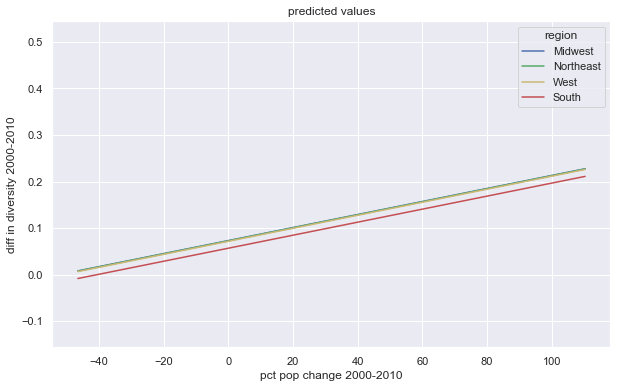

In [35]:
fix, ax = plt.subplots(figsize=(10,6))
colors = 'rbgyrbgy'
for col in combos.region.unique():
    plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
    plt.plot(plt_data.index.get_level_values(0), plt_data['dif_div_pred'], color=colors[int(col)])
    
plt.legend(['Midwest', 'Northeast', 'West', 'South'], loc='upper right', title='region')
plt.xlabel('pct pop change 2000-2010')
plt.ylabel('diff in diversity 2000-2010')
plt.title('predicted values')

plt.ylim(df['div_diff_4grp_9000'].min(), df['div_diff_4grp_9000'].max())

In [1]:
#test